In [1]:
import os
import tqdm
import requests
import zipfile
URL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"

def fetch_data(url=URL, target_file='glove.zip', delete_zip=False):
    #if the dataset already exists exit
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
        return

    #download (large) zip file
    #for large https request on stream mode to avoid out of memory issues
    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall()
    

fetch_data()




**************************
  >_<  Please wait >_< 
**************************


3667580it [24:21, 2510.12it/s]


  Download completed ;) :
1. Extracting glove.zip file


In [15]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maha9\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

Epoch 1/5, Loss: 0.6933, Accuracy: 15.997%
Epoch 2/5, Loss: 0.6931, Accuracy: 15.997%
Epoch 3/5, Loss: 0.6931, Accuracy: 15.997%
Epoch 4/5, Loss: 0.6931, Accuracy: 15.998%
Epoch 5/5, Loss: 0.6931, Accuracy: 15.997%


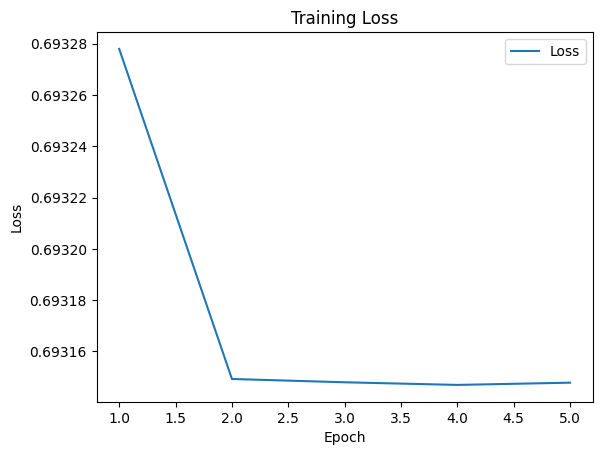

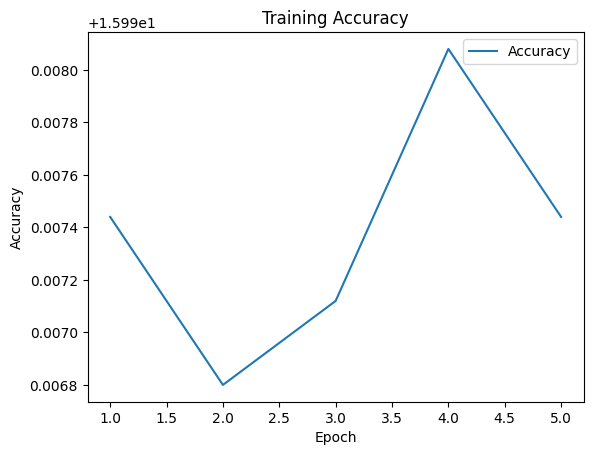

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchtext.vocab import Vectors
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
from nltk import word_tokenize
from nltk.corpus import stopwords


tokenizer = word_tokenize


glove = Vectors(name=r'D:\documents\VI_semester\DL_Lab\glove.42B.300d.txt')


data = pd.read_csv(r"C:\Users\maha9\Downloads\imdb\IMDB Dataset.csv")
data['review'] = data['review'].str.lower()
data['sentiment'] = data['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)


stop_words = set(stopwords.words('english'))

def remove_tags(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'[^a-zA-z0-9\s]', '', text)
    text = re.sub(r"[\"'`]", '', text)
    return text

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) >= 2]
    return ' '.join(tokens)

data['review'] = data['review'].apply(lambda cw: remove_tags(cw))
data['review'] = data['review'].apply(preprocess_text)


embedding_dim = 300
embedding_index = {}
with open(f'glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

word_to_idx = {}
idx_to_word = {}
for index, row in data.iterrows():
    for word in row['review'].split():
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
            idx_to_word[len(word_to_idx) - 1] = word

def load_glove_embeddings(word_to_idx, embedding_dim):
    vocab_size = len(word_to_idx)
    embeddings = np.zeros((vocab_size, embedding_dim), dtype=np.float32)
    for word, idx in word_to_idx.items():
        if word in embedding_index:
            embeddings[idx] = embedding_index[word]
    return torch.tensor(embeddings)

glove_embeddings = load_glove_embeddings(word_to_idx, embedding_dim)


data['review'] = data['review'].apply(lambda tokens: [word_to_idx[word] for word in tokens.split()])

max_length = max(len(seq) for seq in data['review'])
padded_tensor_list = [torch.cat((torch.tensor(seq), torch.zeros(max_length - len(seq), dtype=torch.long))) for seq in data['review']]
tensor_data = torch.stack(padded_tensor_list)


labels = torch.tensor(data['sentiment'].values, dtype=torch.float32)


dataset = TensorDataset(tensor_data, labels)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, embeddings):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return self.sigmoid(output)


vocab_size = len(word_to_idx)
hidden_dim = 128
output_dim = 1
model = LSTMClassifier(embedding_dim, hidden_dim, vocab_size, output_dim, glove_embeddings)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 5
losses = []
acc = []
for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    cnt = 0
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()
        batch_outputs = model(batch_inputs)
        loss = criterion(batch_outputs.squeeze(), batch_targets.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = ((batch_outputs > 5.9355e-06) | (batch_outputs > 0.006)).float()
        total += batch_targets.size(0)
        correct += (predicted == batch_targets).sum().item()
        cnt = cnt + 1
    epoch_loss = total_loss / cnt
    epoch_acc = correct / total
    losses.append(epoch_loss)
    acc.append(epoch_acc)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.3f}%')


import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), acc, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


In [ ]:
r"C:\Users\maha9\Downloads\airlinepassengers\AirPassengers.csv"




Epoch 1/100

7/7 [==============================] - 1s 38ms/step - loss: 0.0537 - val_loss: 0.1042
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0146 - val_loss: 0.0219
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0204
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 0.0164
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0221
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0201
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0156
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0146
Epoch 9/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0139
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0136
Epoch 11/100
7/7 [======

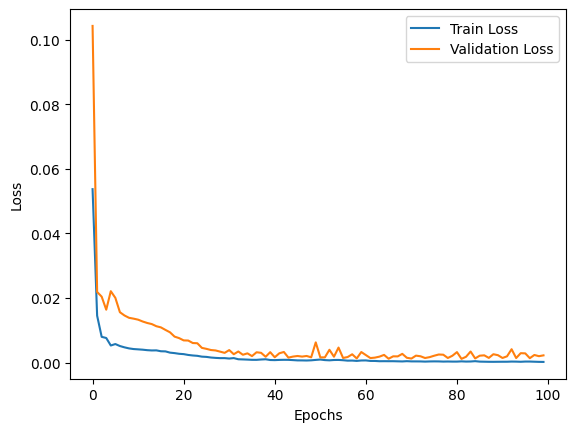

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


data = pd.read_csv(r"C:\Users\maha9\Downloads\airlinepassengers\AirPassengers.csv")
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


look_back = 12  
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i+look_back, 0])
    y.append(data_scaled[i+look_back, 0])
X, y = np.array(X), np.array(y)


X = np.reshape(X, (X.shape[0], X.shape[1], 1))


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


